In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


import wrangle1 as w

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [2]:
df = w.get_explore_data()
df = w.prep_data(df, features=w.features)
df = w.rename_data(df)
train, validate, test = w.split_data(df)

In [3]:
train.head()

,climateregions__climateregion,elevation__elevation,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,contest-precip-14d__precip,contest-pres-sfc-gauss-14d__pres,contest-prwtr-eatm-14d__prwtr,contest-rhum-sig995-14d__rhum,contest-slp-14d__slp,contest-tmp2m-14d__tmp2m,contest-wind-h10-14d__wind-hgt-10,contest-wind-h100-14d__wind-hgt-100,contest-wind-h500-14d__wind-hgt-500,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-wind-vwnd-925-14d__wind-vwnd-925
116277,BSk,1800.0,0.454545,0.300000,2014-10-19,294.86,0.03,83362.52,8.53,28.94,101443.38,16.680867,30825.95,16475.47,5796.30,1504.26,18.22,-0.87,3.46,2.04
237629,Csb,1100.0,0.727273,0.066667,2014-10-25,127.70,63.74,89156.29,16.71,83.14,101841.63,5.987106,30801.60,16340.47,5689.14,1504.33,24.22,1.52,1.08,3.10
272599,BSk,800.0,0.772727,0.700000,2016-06-29,481.48,41.43,89665.38,22.36,54.72,101003.07,21.549640,31605.85,16624.04,5828.97,1492.70,23.68,-0.08,2.35,1.04
205713,Dfb,2000.0,0.636364,0.500000,2015-06-30,453.35,24.78,77957.43,17.11,47.80,101361.57,19.173942,31576.02,16662.35,5875.87,1505.58,15.35,0.50,5.52,1.09
120041,BSk,1900.0,0.454545,0.466667,2015-02-05,135.47,0.00,81613.28,6.06,62.50,102053.60,6.862285,30715.39,16357.43,5755.62,1535.91,19.55,0.42,-10.67,0.27


In [7]:
cont_vars = list(train.select_dtypes(include=np.number).columns)
cat_vars = list(train.select_dtypes(exclude=np.number).columns)

In [9]:
cont_vars.remove('elevation')
cont_vars.remove('lat')
cont_vars.remove('lon')

In [11]:
cont_vars.remove('mean_temp')

In [13]:
cont_vars

['potential_evap',
 'precip',
 'barometric_pressure',
 'all_atmos_precip',
 'relative_humidity',
 'sea_level_press',
 'height_10_mb',
 'height_100_mb',
 'height_500_mb',
 'height_850_mb',
 'zonal_wind_250mb',
 'zonal_wind_925mb',
 'long_wind_250mb',
 'long_wind_925mb']

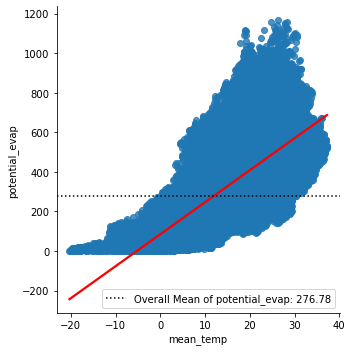

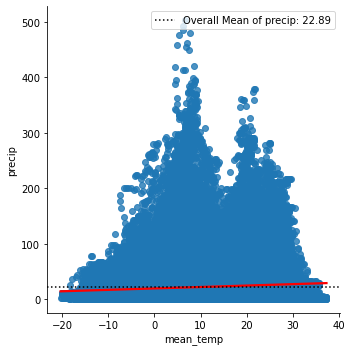

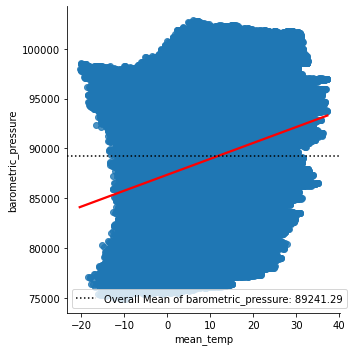

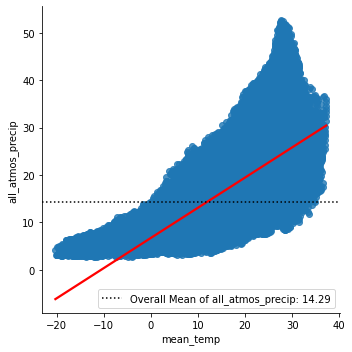

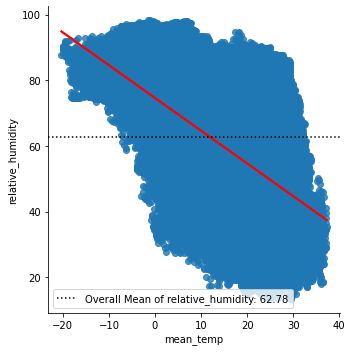

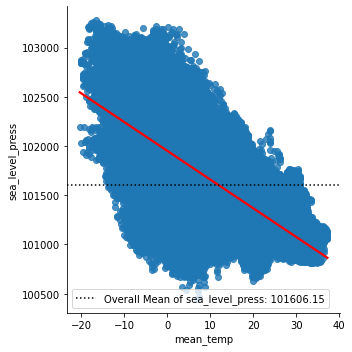

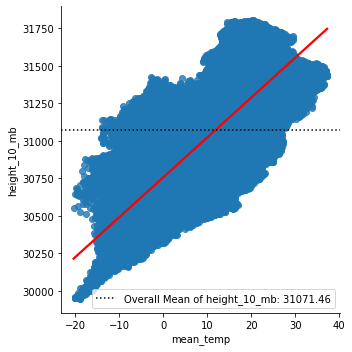

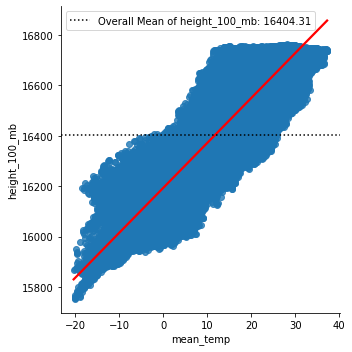

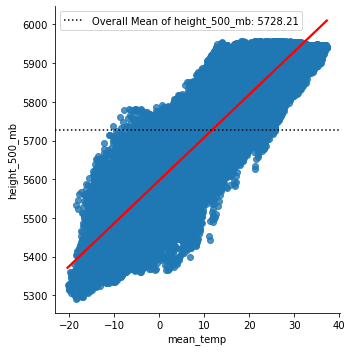

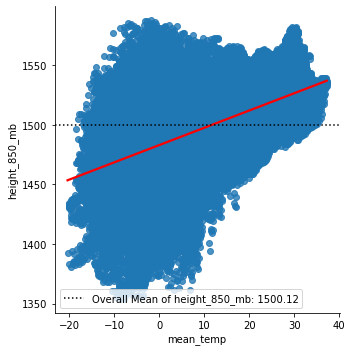

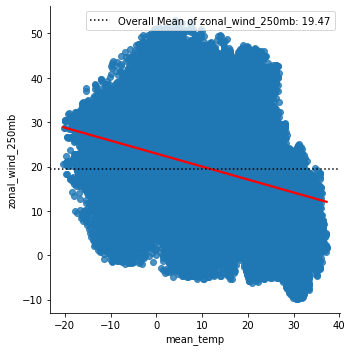

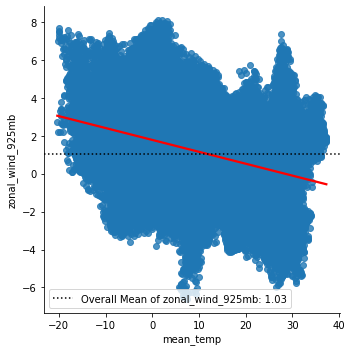

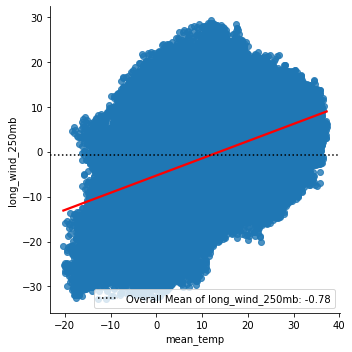

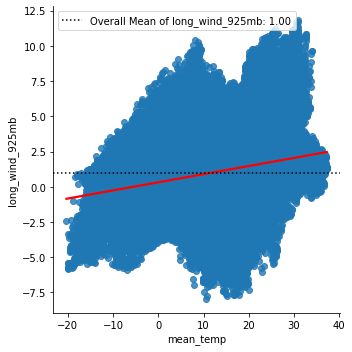

In [17]:
for col in cont_vars:
    sns.lmplot(x='mean_temp', y=col, data=train, line_kws={'color': 'red'})
    rate = train[col].mean()
    plt.axhline(rate,  label = f'Overall Mean of {col}: {rate:.2f}', linestyle='dotted', color='black')
    plt.legend()
    plt.show()

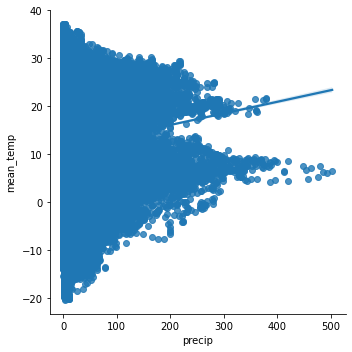

In [16]:
sns.lmplot(x='precip', y='mean_temp', data=train)

In [21]:
time_index = train.set_index('startdate').sort_index()

<AxesSubplot:>

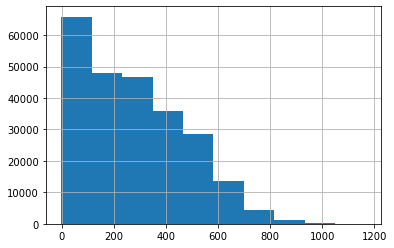

In [23]:
train['potential_evap'].hist()

In [3]:
import sklearn.preprocessing as pre

In [31]:
def create_region_bins(df):
    region_lists = [['BWh', 'BWk', 'Bsh', 'BSk'], ['Csa', 'Csb', 'Cfa', 'Cfa'], ['Dsb', 'Dsc', 'Dwa', 'Dwb', 'Dfa', 'Dfb', 'Dfc']]

    names =['Dry','Temperate','Continental']

    # create a df with mapping information
    maps = (pd.DataFrame({'region_bins': names, 'region': region_lists})
            .explode('region')
            .reset_index(drop=True))

    # join maps
    df = train.merge(maps, on='region', how='left')
    
    return df

In [5]:
region_lists = [['BWh', 'BWk', 'Bsh', 'BSk'], ['Csa', 'Csb', 'Cfa', 'Cfa'], ['Dsb', 'Dsc', 'Dwa', 'Dwb', 'Dfa', 'Dfb', 'Dfc']]

names =['B','C','D']

# create a df with mapping information
maps = (pd.DataFrame({'region_bins': names, 'region': region_lists})
        .explode('region')
        .reset_index(drop=True))

# join maps
validate = validate.merge(maps, on='region', how='left')

In [6]:
def create_elevation_bins(df):
    bins = [0, 500, 1000, 2000, 4000]
    names = ['bottom_low', 'top_low', 'mid', 'high']

    df['elevation_range'] = pd.cut(df['elevation'], bins, labels=names)
    
    return df

In [7]:
def scale_data(train, validate, test):
    '''
    Takes in train, validate, test and a list of features to scale
    and scales those features.
    Returns df with new columns with scaled data
    '''
    scale_features= list(train.select_dtypes(include=np.number).columns)
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    minmax = pre.MinMaxScaler()
    minmax.fit(train[scale_features])
    
    train_scaled[scale_features] = pd.DataFrame(minmax.transform(train[scale_features]),
                                                  columns=train[scale_features].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[scale_features] = pd.DataFrame(minmax.transform(validate[scale_features]),
                                               columns=validate[scale_features].columns.values).set_index([validate.index.values])
    
    test_scaled[scale_features] = pd.DataFrame(minmax.transform(test[scale_features]),
                                                 columns=test[scale_features].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled





In [8]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [24]:
drivers = list(train.columns)
drivers.remove('region')
drivers.remove('startdate')
drivers.remove('elevation')
drivers.remove('mean_temp')

In [25]:
X_train = train_scaled[drivers]
dummy_df_train = pd.get_dummies(X_train[['region_bins','elevation_range']], dummy_na=False, drop_first=[True, True])
X_train = pd.concat([X_train, dummy_df_train], axis=1).drop(columns=['region_bins','elevation_range'])
y_train = train['mean_temp']

In [26]:
X_validate = validate_scaled[drivers]
dummy_df_validate = pd.get_dummies(X_validate[['region_bins','elevation_range']], dummy_na=False, drop_first=[True, True])
X_validate = pd.concat([X_validate, dummy_df_validate], axis=1).drop(columns=['region_bins','elevation_range'])
y_validate = validate['mean_temp']

In [16]:
import model as m

In [27]:
m.regression_models(X_train, y_train, X_validate, y_validate)

,model,RMSE_train,r^2_train,RMSE_validate,r^2_validate
0,OLS Regressor,1.868533,0.964563,1.865077,0.964958
1,Lasso_alpha_1,9.925980,0.000000,9.963322,0.000000
2,Quadratic,1.427490,0.979318,1.426547,0.979499


In [28]:
m.baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,9.925980,9.963322,-0.037342
1,median_baseline,9.937875,9.974187,-0.036312


In [29]:
import sklearn.metrics as metric

In [30]:
metric.mean_squared_error(
            y_train,
            y_train.mean()) ** .5

TypeError: Expected sequence or array-like, got <class 'float'>